In [301]:
import pandas as pd
import glob
import os
    
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from Bio import SeqIO

import xmltodict
from flatten_json import flatten
import json

In [202]:
pgap_hmm['family_type'].value_counts()

equivalog                  10928
domain                      8161
subfamily                   3363
PfamEq                      2260
PfamAutoEq                  1217
exception                    918
hypoth_equivalog             456
equivalog_domain             204
subfamily_domain             198
repeat                       117
hypoth_equivalog_domain       39
paralog                       28
superfamily                   27
paralog_domain                15
signature                      5
Name: family_type, dtype: int64

In [203]:
rule_precedences = {
'BlastRuleIS':96,
'BlastRuleException':95,
'exception':77,
'equivalog':70,
'hypoth_equivalog':70,
'equivalog_domain':70,
'hypoth_equivalog_domain':70,
'BlastRuleEquivalog':69,
'BlastRuleSubPlus':65,
'Domain architecture':60,
'PfamEq':57,
'subfamily':55,
'subfamily_domain':52,
'BlastRuleSubMinus':50,
'BlastRuleCOLLAB':41,
'PfamAutoEq':37,
'paralog':36,
'paralog_domain':35,
'superfamily':33,
'domain':30,
'repeat':25,
'signature':22
}

In [384]:
"""
############### SPARCLE ###############
"""
# function to read xml
def read_sparcle_xml(file_path):
    with open(file_path, 'r') as xml_handle:
        xml_data = xml_handle.read()
    return read_xml_as_df(xml_data)    

# function to turn string of xml into a file path
def read_xml_as_df(xml_to_parse):
    #this will create a json object
    data = json.loads(json.dumps(xmltodict.parse(xml_to_parse)))

    # this will put all items into a single row
    dic_flattened = (flatten(d, '.') for d in data['NameAssignment']['Protein'])
    df = pd.DataFrame(dic_flattened)
    return df

# function to parse sparcle data 
def parse_sparcle_data(df):
    df['orf_uid'] = sparcle_data['@seq-id'].apply(lambda x: x.split('|')[1])
    df = df.rename(columns={'AssignedName':'name',
                       'Support.SPARCLE.SpecificArch':'assignment_acc',
                       'Precedence.confidence':'precedence'})
    df['precedence'] = df['precedence'].astype(int)
    columns = ['orf_uid', 'name', 'assignment_acc', 'precedence']
    return df[columns]

"""
############### HMM ###############
"""
hmm_table_columns = ['target_name','target_accession','query_name','query_accession', 
                      'full_e_value', 'full_score', 'full_bias', 
                      'best_domain_e_value', 'best_domain_score', 'best_domain_bias', 
                      'exp', 'reg', 'clu',  'ov', 'env', 'dom', 'rep', 'inc']

# function to read HMMER3.0 tblout as pandas df
def read_hmm_table_pandas(file_path):
    # read table with special parameters
    pfam_as_table = pd.read_table(file_path, skiprows=3,  skipfooter=10, sep='\s+', header=None, engine='python', usecols=list(range(18)))
    pfam_as_table.columns = hmm_table_columns
    return pfam_as_table

def parse_hmm_data(df, hmm_md, precedences):
    # merge with hmm data
    merged = pd.merge(df, hmm_md[['#ncbi_accession', 'product_name', 'sequence_cutoff', 'domain_cutoff', 'family_type']],
         left_on='query_accession', right_on='#ncbi_accession')
    # subset to hits
    merged = merged[(merged.full_score >= merged.sequence_cutoff) & (merged.best_domain_score >= merged.domain_cutoff)]
    # reformat columns
    merged['precedence'] = merged['family_type'].map(precedences).astype(int)
    merged = merged.rename(columns={'target_name':'orf_uid',
                                    'query_accession':'assignment_acc',
                                    'product_name':'name'})
    columns = ['orf_uid', 'name', 'assignment_acc', 'precedence']
    return merged[columns]

"""
############### BLAST ###############
"""

blast6_fmt_str = '"6 qseqid sseqid pident length mismatch gapopen qlen qstart qend slen sstart send evalue bitscore"'

def read_blast_table(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None)
    data.columns = blast6_fmt_str.replace('"', '').split(' ')[1:]
    
    return data

def parse_blast_data(df, blastrules_md, precedences):
    
    df['scov'] = (df['send'] - df['sstart']) / df['slen']
    df['qcov'] = (df['qend'] - df['qstart']) / df['qlen']
    
    # split acc column
    df['assignment_acc'] = df['sseqid'].apply(lambda x: x.split('|')[3].split('.')[0])

    blastrules_cols = ['Name', 'WP_Proteins', 'Identity', 'Model_pct', 'Target_pct', 'Rule_type']
    data_cols = ['qseqid', 'assignment_acc', 'pident', 'scov', 'qcov']
    
    # merge with metadata to get cutoffs and precedence
    merged = pd.merge(df[data_cols], blastrules_md[blastrules_cols], left_on='assignment_acc', right_on='WP_Proteins')

    # filter
    merged = merged[(merged['pident'] >= merged['Identity'])
                & (merged['scov'] >= merged['Model_pct'])
                & (merged['qcov'] >= merged['Target_pct'])]

    # add precedence
    merged['precedence'] = merged['Rule_type'].map(precedences).astype(int)
    columns = ['orf_uid', 'name', 'assignment_acc', 'precedence']
    
    # renaming
    merged = merged.rename(columns={'qseqid':'orf_uid',
                                'Name':'name'})
    return merged[columns]

## SparcleLabel ribosomal protein annotation process

### Steps
1. Get cddid_tbl.gz
```
wget https://ftp.ncbi.nih.gov/pub/mmdb/cdd/cddid.tbl.gz
```
on May 26, 2022
2. Get cdd
```
wget cdd.tar.gz
tar -xzf cdd.tar.gz
mkdir smp
mv *.smp smp
```

In [6]:
cddid_tbl = pd.read_csv('/data/mhoffert/db/cdd/cddid.tbl', sep='\t', header=None)
cddid_tbl.columns = '''PSSM-Id
CD accession
CD short name
CD description
PSSM-Length'''.split('\n')

In [13]:
psms = glob.glob('/data/mhoffert/db/cdd/smp/*')

In [14]:
psms[0]

'/data/mhoffert/db/cdd/smp/cd00001.smp'

In [16]:
ribosomal_proteins = cddid_tbl[cddid_tbl['CD description'].str.contains('ribosomal protein')]['CD accession'].values

smp_list = [f'/data/mhoffert/db/cdd/smp/{protein}.smp' for protein in ribosomal_proteins if f'/data/mhoffert/db/cdd/smp/{protein}.smp' in psms]

In [19]:
with open('/data/mhoffert/db/cdd/ribosomal_proteins.pn', 'w') as pn_file:
    pn_file.write('\n'.join(smp_list))

```
~/tools/SparcleLabel/SparcleLabel-x64-linux/ncbi-blast-2.13.0+/bin/makeprofiledb -title ribosomal_proteins -in ribosomal_proteins.pn -out ribosomal_proteins -threshold 9.92 -scale 100.0 -dbtype rps -index true
```

## PGAP HMM ribosomal protein process

### Steps
1. Get PGAP hmms and unpack
```
wget https://ftp.ncbi.nih.gov/hmm/current/hmm_PGAP.HMM.tgz
tar -xzvf hmm_PGAP.HMM.tgz
```
2. Read tsv file
```
https://ftp.ncbi.nih.gov/hmm/current/hmm_PGAP.tsv
```

In [122]:
pgap_hmm = pd.read_csv('/data/mhoffert/db/pgap_ribosomal/hmm_PGAP.tsv', sep='\t')

In [53]:
pgap_hmm.family_type.value_counts()

equivalog                  10928
domain                      8161
subfamily                   3363
PfamEq                      2260
PfamAutoEq                  1217
exception                    918
hypoth_equivalog             456
equivalog_domain             204
subfamily_domain             198
repeat                       117
hypoth_equivalog_domain       39
paralog                       28
superfamily                   27
paralog_domain                15
signature                      5
Name: family_type, dtype: int64

In [36]:
hmms = glob.glob('/data/mhoffert/db/pgap_ribosomal/hmm_PGAP/*.HMM')

In [38]:
ribosomal_hmms = pgap_hmm[pgap_hmm.product_name.str.contains('ribosomal protein')]['#ncbi_accession'].unique()

hmm_list = [f'/data/mhoffert/db/pgap_ribosomal/hmm_PGAP/{acc}.HMM' for acc in ribosomal_hmms if f'/data/mhoffert/db/pgap_ribosomal/hmm_PGAP/{acc}.HMM' in hmms]

In [44]:
for i, hmm in enumerate(hmm_list):
    display(i)
    clear_output(wait=True)
    os.system(f'cat {hmm} >> /data/mhoffert/db/pgap_ribosomal/ribosomal_hmm')

244

Press HMMs according to these instructions: http://eddylab.org/software/hmmer3/3.1b2/Userguide.pdf pp 33
```
hmmpress ribosomal_hmm
```

In [46]:
pgap_hmm.columns.values

array(['#ncbi_accession', 'source_identifier', 'label', 'sequence_cutoff',
       'domain_cutoff', 'hmm_length', 'family_type',
       'for_structural_annotation', 'for_naming', 'for_AMRFinder',
       'product_name', 'gene_symbol', 'ec_numbers', 'go_terms', 'pmids',
       'taxonomic_range', 'taxonomic_range_name', 'taxonomic_rank_name',
       'n_refseq_protein_hits', 'source', 'name_orig'], dtype=object)

### Blastrules

Download proteins and blastrules:
    ```
    https://ftp.ncbi.nih.gov/pub/blastrules/RELEASE_4.0/
    ```

In [111]:
blastrules = pd.read_csv('/data/mhoffert/db/pgap_ribosomal/blastrules_4.0/blast-rules_4.0.tsv', sep='\t', encoding='latin1')

In [59]:
ribosomal_blastrules = [p for plist in blastrules[blastrules['Name'].str.contains('ribosomal protein')]['WP_Proteins'].apply(lambda x: x.split(',')) for p in plist]

In [64]:
with open('/data/mhoffert/db/pgap_ribosomal/blastrules_4.0/proteins.fasta', 'r') as proteins_fasta:
    records = [r for r in SeqIO.parse(proteins_fasta, format='fasta')]
    

In [65]:
ribosomal_records = [r for r in records if any(s in r.id for s in ribosomal_blastrules) ]

In [68]:
with open('/data/mhoffert/db/pgap_ribosomal/blastrules_4.0/ribosomal_proteins.fasta', 'w') as ribosomal_proteins_fasta:
    SeqIO.write(ribosomal_records, ribosomal_proteins_fasta, 'fasta')

```
makeblastdb -in ribosomal_proteins.fasta -dbtype prot -out ribosomal_proteins
```

### Test pipeline

In [239]:
eggo_data = pd.read_csv('/data/mhoffert/tools/eggo/Data/EGGO.csv')

Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.


In [246]:
eggo_data.head()

,Unnamed: 0,nHE,FilteredSequences,d,LowerCI,UpperCI,d.madin,LowerCI.madin,UpperCI.madin,Assembly,Source,Mode,Type,Environment
0,1,53,78,4.953194,3.678089,6.758172,4.167909,3.217277,5.452817,GCF_004214875.1_ASM421487v1,RefSeq Assemblies,Full,Isolate,NaN
1,2,53,199,5.045133,3.771657,6.833362,4.350184,3.370865,5.667857,GCF_000744065.1_ASM74406v1,RefSeq Assemblies,Full,Isolate,NaN
2,3,54,37,4.306077,3.037874,6.215246,3.271171,2.437223,4.446947,GCF_009268075.1_ASM926807v1,RefSeq Assemblies,Full,Isolate,NaN
3,5,59,1674,9.618230,7.245196,12.920418,9.329283,7.392557,11.866987,GCF_000196515.1_ASM19651v1,RefSeq Assemblies,Full,Isolate,NaN
4,6,54,38,4.253248,2.979781,6.186532,3.210227,2.378910,4.389904,GCF_009268105.1_ASM926810v1,RefSeq Assemblies,Full,Isolate,NaN


<AxesSubplot:xlabel='d', ylabel='Count'>

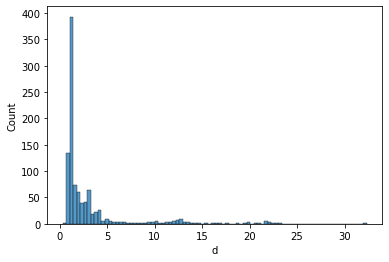

In [306]:
sns.histplot(eggo_data.head(1000)['d'])

In [256]:
test_genomes = []
for index, row in eggo_data.head(500).iterrows():
    genome_id = 'RS_'+'_'.join(row['Assembly'].split('_')[:2])
    # print(genome_id)
    if os.path.exists(f'/data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/{genome_id}_protein.faa'):
        test_genomes.append(f'{genome_id}')
    

In [257]:
with open('/data/mhoffert/realmichaelhoffert/ribosomal_proteins/test_genomes_list.txt', 'w') as handle:
    handle.write('\n'.join(test_genomes))

In [3]:
for test_genome in test_genomes
test_genome = '/data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/RS_GCF_009268075.1_protein.faa'
test_genome_split = test_genome.split('/')[-1].replace('_protein.faa', '')
out_path = f'/data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/{test_genome_split}'

out_path

'/data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009268075.1'

In [4]:
main_wd = '/data/mhoffert/realmichaelhoffert/ribosomal_proteins/notebooks/'

In [5]:
os.getcwd()

'/data/mhoffert/tools/SparcleLabel/SparcleLabel-x64-linux'

### First: Sparcle pipeline
Run from installation directory for Sparcle pipeline

In [8]:
print(f'./rpsblast -parse_deflines -query {test_genome} -db /data/mhoffert/db/cdd/ribosomal_proteins -evalue 0.01 -outfmt 11 -out {out_path}.asn')
print(f'./sparclbl -p precedences_sample.txt -o {out_path}.xml {out_path}.asn')


/data/mhoffert/tools/SparcleLabel/SparcleLabel-x64-linux
running command 1
./rpsblast -parse_deflines -query /data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/RS_GCF_009268075.1_protein.faa -db /data/mhoffert/db/cdd/ribosomal_proteins -evalue 0.01 -outfmt 11 -out /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009268075.1.asn
/data/mhoffert/tools/SparcleLabel/SparcleLabel-x64-linux
running command 2
./sparclbl -p precedences_sample.txt -o /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009268075.1.xml /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009268075.1.asn


Run: `./run_ribosomal_pipeline.sh /data/mhoffert/realmichaelhoffert/ribosomal_proteins/test_genomes_list.txt` from /data/mhoffert/realmichaelhoffert/ribosomal_proteins/  
For some reason, running the commands in the jupter notebook doesn't work

### Second: HMM pipeline

In [268]:
faa_path = '/data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/'
for i, test_genome in enumerate(test_genomes):
    display(f'{i / len(test_genomes) * 100:.2f}%')
    clear_output(wait=True)
    
    out_path = f'/data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/{test_genome}'
    os.system(f'hmmsearch --cpu 8 -o {out_path}.hmmout --tblout {out_path}.tblout /data/mhoffert/db/pgap_ribosomal/ribosomal_hmm {faa_path}{test_genome}_protein.faa')

'99.32%'

In [267]:
print(f'hmmsearch --cpu 8 -o {out_path}.hmmout --tblout {out_path}.tblout /data/mhoffert/db/pgap_ribosomal/ribosomal_hmm {faa_path}{test_genome}_protein.faa')

hmmsearch --cpu 8 -o /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_000687875.1.hmmout --tblout /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_000687875.1.tblout /data/mhoffert/db/pgap_ribosomal/ribosomal_hmm /data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/RS_GCF_000687875.1_protein.faa


### Third: blast pipeline

In [269]:
%%time
blast_db = '/data/mhoffert/db/pgap_ribosomal/blastrules_4.0/ribosomal_proteins'
blast6_fmt_str = '"6 qseqid sseqid pident length mismatch gapopen qlen qstart qend slen sstart send evalue bitscore"'
for i, test_genome in enumerate(test_genomes):
    display(f'{i / len(test_genomes) * 100:.2f}%')
    clear_output(wait=True)
    
    out_path = f'/data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/{test_genome}'
    os.system(f'blastp -num_threads 8 -query {faa_path}{test_genome}_protein.faa -db {blast_db} -out {out_path}.blast6out -outfmt {blast6_fmt_str}')

CPU times: user 404 ms, sys: 104 ms, total: 508 ms
Wall time: 34min 32s


## Parsing results

In [385]:
for i, test_genome in enumerate(test_genomes):
    display(f'{i / len(test_genomes) * 100:.2f}%')
    clear_output(wait=True)
    
    out_path = f'/data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/{test_genome}'
    
    # parse the sparcle data
    sparcle_data = read_sparcle_xml(f'{out_path}.xml')
    sparcle_df = parse_sparcle_data(sparcle_data)

    # parse the blast data
    blast_data = read_blast_table(f'{out_path}.blast6out')
    blast_df = parse_blast_data(blast_data, blastrules, rule_precedences)

    # parse the hmm data
    hmm_data = read_hmm_table_pandas(f'{out_path}.tblout')
    hmm_df = parse_hmm_data(hmm_data, pgap_hmm, rule_precedences)

    # for df in [sparcle_df, blast_df, hmm_df]:
    #     print(df.shape)
    # time.sleep(1)

    all_ribosomal_proteins = pd.concat([sparcle_df, blast_df, hmm_df])

    selected_ribosomal_annotations = all_ribosomal_proteins.groupby('orf_uid').apply(lambda x: x.sort_values('precedence', ascending=False).iloc[0, :])

    # test_genome_split

    nt_fasta_base_path = '/data/mhoffert/genomes/GTDB_r207/protein_fna_reps/bacteria/'
    nt_fasta = f'{nt_fasta_base_path}{test_genome}_protein.fna'

    # import time

    with open(nt_fasta, 'r') as input_fasta:
        records = [r for r in SeqIO.parse(input_fasta, 'fasta')]

    for r in records:
        if r.id in selected_ribosomal_annotations.index:
            annotation = selected_ribosomal_annotations.loc[r.id]
            r.id = f'{r.id} {annotation["name"]} ({annotation["assignment_acc"]})'
            r.description = ' '.join(r.description.split(' ')[1:])

    with open(f'/data/mhoffert/genomes/GTDB_r207/grodon_format/{test_genome}_grodon_format.fna', 'w') as out_handle:
            SeqIO.write(records, out_handle, 'fasta')

'99.32%'

In [386]:
test_data = pd.read_csv('/data/mhoffert/test.csv', index_col=0)

In [387]:
test_data['genome'] = test_data['paths'].apply(lambda x: x.split('/')[-1].split('_grodon')[0])

In [388]:
eggo_data['genome'] = eggo_data['Assembly'].apply(lambda x: 'RS_'+'_'.join(x.split('_')[:2]))

In [389]:
eggo_measurements = eggo_data[eggo_data.genome.isin(test_data.genome.values)].set_index('genome').reindex(test_data['genome'].values)['d']

In [390]:
test_measurements = test_data.set_index('genome')['result_list']

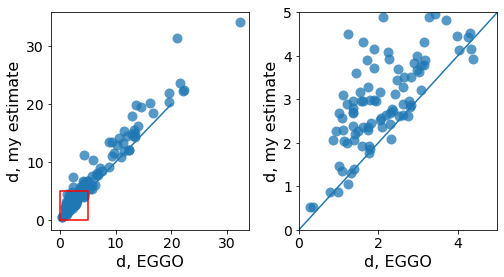

In [402]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x=eggo_measurements, 
                y=test_measurements,
                linewidth=0, alpha=0.75, s=100)
plt.plot((0, 20), (0, 20))
plt.tick_params(labelsize=14)
ax.set_ylabel('d, my estimate', fontsize=16)
ax.set_xlabel('d, EGGO', fontsize=16)
plt.plot((0, 0, 5, 5, 0), (0, 5, 5, 0, 0), color='r')
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 5)

ax = fig.add_subplot(1,2,2)
sns.scatterplot(x=eggo_measurements, 
                y=test_measurements,
                linewidth=0, alpha=0.75, s=100)
plt.plot((0, 20), (0, 20))
plt.tick_params(labelsize=14)
ax.set_ylabel('d, my estimate', fontsize=16)
ax.set_xlabel('d, EGGO', fontsize=16)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
fig.subplots_adjust(wspace=0.25)

In [364]:
from scipy.stats import spearmanr

In [392]:
spearmanr(eggo_measurements, test_measurements)

SpearmanrResult(correlation=0.9098406485882025, pvalue=2.961441188763098e-57)

In [371]:
eggo_measurements.index[eggo_measurements.argmax()]

'RS_GCF_010378095.1'

In [363]:
eggo_measurements.head(20) - test_measurements.head(20)

genome
RS_GCF_000018105.1   -5.041994
RS_GCF_000018785.1   -0.051609
RS_GCF_000021485.1   -0.317926
RS_GCF_000022565.1   -1.625586
RS_GCF_000023265.1   -0.110809
RS_GCF_000025305.1   -1.669807
RS_GCF_000144695.1    0.163678
RS_GCF_000154285.1   -0.269343
RS_GCF_000160075.2   -0.244850
RS_GCF_000160455.2   -2.168722
RS_GCF_000165835.1   -1.188871
RS_GCF_000175575.2    0.325437
RS_GCF_000196455.1   -1.843861
RS_GCF_000196515.1   -2.003609
RS_GCF_000202835.1   -0.812571
RS_GCF_000219125.1   -6.128773
RS_GCF_000236785.1   -1.358713
RS_GCF_000238775.1   -3.581516
RS_GCF_000247605.1   -1.764848
RS_GCF_000376245.1   -0.462640
dtype: float64

In [335]:
eggo_measurements.head(20)

genome
RS_GCF_000018105.1     9.289777
RS_GCF_000018785.1     2.825539
RS_GCF_000144695.1     6.271416
RS_GCF_000154285.1     1.084743
RS_GCF_000160075.2     0.285282
RS_GCF_000160455.2    16.619129
RS_GCF_000165835.1     1.792963
RS_GCF_000196455.1     3.904831
RS_GCF_000196515.1     9.618230
RS_GCF_000219125.1    13.647700
RS_GCF_000236785.1     1.353153
RS_GCF_000238775.1    10.573170
RS_GCF_000247605.1     5.734336
RS_GCF_000376245.1     3.995577
RS_GCF_000429165.1     1.901692
RS_GCF_000472665.1     1.607256
RS_GCF_000483165.1     1.237994
RS_GCF_000526235.1     2.974528
RS_GCF_000613285.1     3.288427
RS_GCF_000613865.1     2.831328
Name: d, dtype: float64

In [303]:
test_genome

'RS_GCF_900103005.1'